In [1]:
import json
import ROOT
from analysis_framework import Dataset
from WWAnalysis import WWAnalysis
import os

OBJ: TStyle	ildStyle	ILD Style : 0 at: 0x804f8f0


In [2]:
# ROOT.EnableImplicitMT(12)

In [3]:
# CLD
# x_angle = 0.030 # rad
# ILD
x_angle = 0.014 # rad

In [4]:
# dataset = Dataset.from_json("data/datasets/snapshots/full.json")
# dataset = Dataset.from_json("checked-test.json")
# dataset = Dataset.from_json("checked-full.json")
dataset = Dataset.from_json("checked-full-local.json")

In [5]:
analysis = WWAnalysis(dataset)
analysis.init_parameters([
    # ("WWCategorisation.RecoCatBasic", "int", "8"),
    # ("WWCategorisation.RecoCatAdvanced", "int", "8"),
    # ("WWCategorisation.missE", "float", "-42"),
    # ("WWCategorisation.misspT", "float", "-42"),
    # ("WWCategorisation.mInv", "float", "-42"),
    ("Energy", "float", "-42"),
    ("sqme", "float", "-42.0"),
])

Warning in <TClass::Init>: no dictionary for class edm4hep::Vector2i is available


In [ ]:
alt_configs = {
    "alt1": {
        "g1z": 1.001,
        "ka": 1.000,
        "la": 0.000,
    },
    "alt2": {
        "g1z": 1.000,
        "ka": 1.001,
        "la": 0.000,
    },
    "alt3": {
        "g1z": 1.000,
        "ka": 1.000,
        "la": 0.001,
    },
}
analysis.initialise_omega_wrappers(alt_configs)

In [7]:
mc_indices = {
    "beam_e_nominal": 0,
    "beam_p_nominal": 1,
    "beam_e_BES": 2,
    "beam_p_BES": 3,
    "beam_e_ISR": 4,
    "beam_p_ISR": 5,
    "up_type_q": 10,
    "down_type_q": 11,
    "charged_lep": 12,
    "neutrino": 13,
}
analysis.set_mc_indices(mc_indices)

In [8]:
# signal cut goes here:
# In this case, we want to require the charged lepton in the final state to be inside of the detector acceptance
# just take the first gen status 1 particle with a fitting pdg value and cut on theta
lep_pdg = 11
# CLD 150 mrad
# ILD ~84 mrad (IDR: 4.8 deg)
acceptance_theta = 0.084
signal_cut = f"""
std::invoke([](auto& genStat, auto& pdg, auto& px, auto& py, auto& pz, auto& m) -> bool {{
auto lepton_mask = genStat == 1 && abs(pdg) == {lep_pdg};
// abuse ArgMax to get the first set position
auto lepton_idx = ArgMax(lepton_mask);
auto lepton_lvec = ROOT::Math::PxPyPzMVector(px[lepton_idx], py[lepton_idx],
                                             pz[lepton_idx], m[lepton_idx]);
double lepton_theta = lepton_lvec.Theta();
return abs(cos(lepton_theta)) < cos({acceptance_theta});
}}, MCParticlesSkimmed.generatorStatus, MCParticlesSkimmed.PDG, MCParticlesSkimmed.momentum.x, MCParticlesSkimmed.momentum.y, MCParticlesSkimmed.momentum.z, MCParticlesSkimmed.mass)
"""

In [9]:
analysis.set_categories({
    # TODO: actually implement the cut, but I might notice when refactoring the cut-flow...
    # "4f_sw_sl_signal": {"pattern": "4f_sw_sl", "cut": "1 == 1"},
    # TODO: in principle I would not need to define them like this again if I would use the information from the pre-selection but did not manage that on first try :(
    "4f_sw_sl_signal": {"pattern": "4f_sw_sl", "cut": signal_cut},
    "4f_sl_bkg": {"pattern": r"4f\w+sl", "cut": None }, # inverse signal cut will be applied automatically
    "4f_not_sl": {"pattern": r"4f\w+_(?:h|l)", "cut": None },
    # separate out aa_4f? super low lumi anyway
    "aa2f": {"pattern": "aa_2f", "cut": None},
    # 2f but not aa_2f
    "2f": {"pattern": "(?<!aa_)2f", "cut": None},
    "3f": {"pattern": "ea_3f|ae_3f", "cut": None},
    "5f": {"pattern": "ea_5f|ae_5f", "cut": None},
    "6f": {"pattern": "6f", "cut": None},
    # need to filter out anything ending in _h and 2f_z_eehiq
    "higgs": {"pattern": "[^_e]h", "cut": None},
})
# check if we missed any processes
print(analysis.is_complete_categorisation())
analysis.set_signal_categories(["4f_sw_sl_signal"])

True


In [10]:
# FIXME: get rid of all the double signal_signal etc. :(
print(json.dumps(analysis._categories, indent=2))

{
  "4f_sw_sl_signal": [
    "4f_sw_sl_eLpL_signal_signal",
    "4f_sw_sl_eLpR_signal_signal",
    "4f_sw_sl_eRpR_signal_signal",
    "4f_sw_sl_eRpL_signal_signal",
    "4f_sw_sl_eLpL_bkg_signal",
    "4f_sw_sl_eLpR_bkg_signal",
    "4f_sw_sl_eRpR_bkg_signal",
    "4f_sw_sl_eRpL_bkg_signal"
  ],
  "4f_sl_bkg": [
    "4f_zz_sl_eLpR",
    "4f_zz_sl_eRpL",
    "4f_zznu_sl_eLpR",
    "4f_zznu_sl_eRpL",
    "4f_sze_sl_eLpL",
    "4f_sze_sl_eLpR",
    "4f_sze_sl_eRpR",
    "4f_sze_sl_eRpL",
    "4f_sznu_sl_eLpR",
    "4f_sznu_sl_eRpL",
    "4f_ww_sl_eLpR",
    "4f_ww_sl_eRpL",
    "4f_sw_sl_eLpL_signal_bkg",
    "4f_sw_sl_eLpR_signal_bkg",
    "4f_sw_sl_eRpR_signal_bkg",
    "4f_sw_sl_eRpL_signal_bkg",
    "4f_sw_sl_eLpL_bkg_bkg",
    "4f_sw_sl_eLpR_bkg_bkg",
    "4f_sw_sl_eRpR_bkg_bkg",
    "4f_sw_sl_eRpL_bkg_bkg"
  ],
  "4f_not_sl": [
    "4f_zz_h_eLpR",
    "4f_zz_h_eRpL",
    "4f_zz_l_eLpR",
    "4f_zz_l_eRpL",
    "4f_zzorww_h_eLpR",
    "4f_zzorww_l_eLpR",
    "4f_zzorww_l_eRpL",
    "

In [11]:
# needed for the .size() calls... alternative would probably be to .Alias the @size columns
ROOT.gInterpreter.Declare("#include <podio/ObjectID.h>")
ROOT.gInterpreter.Declare("#include <edm4hep/ReconstructedParticleData.h>")
make_lvec = lambda coll_name: f"ROOT::VecOps::Construct<ROOT::Math::PxPyPzEVector>({coll_name}.momentum.x, {coll_name}.momentum.y, {coll_name}.momentum.z, {coll_name}.energy)"
analysis.Define("R2jet_lvecs", make_lvec("Refined2Jets"))

In [12]:
signal_category = ["4f_sw_sl_signal"]
analysis.define_truth_objects(signal_category)
analysis.book_weights()
analysis.define_reco_objects(x_angle)
analysis.remove_x_angle(x_angle)
analysis.define_hagiwara_angles()

In [13]:
# filter on missing energy > 0
analysis.Define("nu_E", "ub_nu_lvec.energy()")
analysis.Define("M_Wlep", "ub_leptonic_W_lvec.M()")
analysis.Define("M_Whad", "ub_hadronic_W_lvec.M()")
analysis.add_filter("M_Wlep > 0.", "Wlep real")

In [14]:
# analysis.book_reports()

In [15]:
analysis.book_histogram_1D("weight_alt1", "weight_alt1", ("", ";weight_alt1", 50, 0.8, 1.2), categories=signal_category)

In [16]:
%%time
analysis.run()

CPU times: user 2h 21min 43s, sys: 30.6 s, total: 2h 22min 14s
Wall time: 12min 38s
OBJ: TStyle	ildStyle	ILD Style : 0 at: 0x37f2a170


(<cppyy.gbl.THStack object at 0x3ff01c50>,
 <cppyy.gbl.TCanvas object at 0x40120590>)

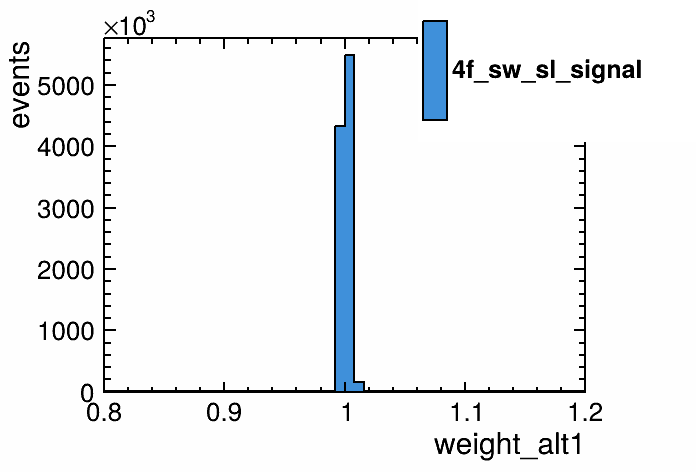

In [17]:
analysis.draw_histogram("weight_alt1", categories=signal_category)